# Prepare data for MATSim simulation

In [1]:
%load_ext autoreload
%autoreload 2
%cd D:\sysmo-data
%matplotlib inline

D:\sysmo-data


In [2]:
# Load libs
import pandas as pd
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import matsim
import gzip
import numpy as np
from tqdm.notebook import tqdm

In [6]:
# Load Sweden municipalities
gdf = gpd.read_file("dbs/geo/sweden_komk.shp")

# Multiple regions
tv = {
    'palt20': (20, ),
    'palt21': (21, ),
    'palt22': (22, ),
    'palt23': (23, ),
    'palt24': (24, ),
    'palt25': (25, ),
    'samm': (1, 3, 4, 9, 18, 19),
    'skane': (12, ),
    'sydost': (5, 6, 7, 8, 10),
    'vast13': (13, ),
    'vast14': (14, ),
    'vast17': (17, )
      }
tv_mapping = {x: k for k, v in tv.items() for x in v}
gdf.loc[:, 'lan'] = gdf['KnKod'].apply(lambda x: int(x[:2]))
gdf.loc[:, 'tv_zone'] = gdf.loc[:, 'lan'].apply(lambda x: tv_mapping[x])

## 1. Network boundaries

<Axes: >

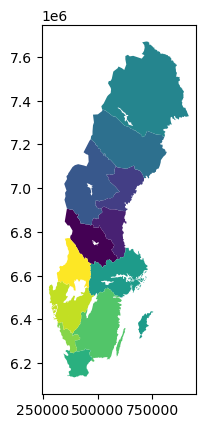

In [7]:
gdf_zone = gdf[['tv_zone', 'geometry']].dissolve('tv_zone').reset_index()
gdf_zone.plot(column='tv_zone', cmap = "viridis")

<Axes: >

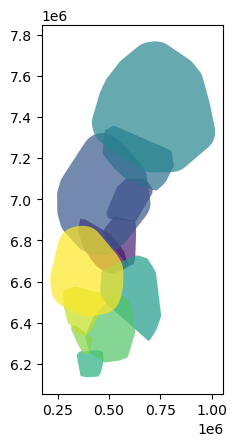

In [9]:
# Calculate the unary union of all the polygons
polygon_list = []
z_list = []
for z in tv:
    unioned = gdf_zone.loc[gdf_zone['tv_zone'] == z].unary_union
    # Get the convex hull of the unioned geometry
    if z in ('vast17', 'palt23', 'palt25'):
        convex_hull = unioned.convex_hull.buffer(100000)
    else:
        convex_hull = unioned.convex_hull
    polygon_list.append(convex_hull)
    z_list.append(z)
# Create a new GeoDataFrame from the convex hull
convex_gdf = gpd.GeoDataFrame(geometry=polygon_list)
convex_gdf.loc[:, 'tv_zone'] = z_list
convex_gdf.plot(column='tv_zone', cmap = "viridis", alpha=0.7)

In [10]:
# Save the convex hull to a new file
for z, poly in zip(z_list, polygon_list):
    convex_gdf = gpd.GeoDataFrame(geometry=[poly])
    convex_gdf.to_file(f"dbs/geo/zones/{z}.shp")

## 2. Network processing using Java code

In [ ]:
Epsg = "EPSG:3006"
input = "D:\\sysmo-data\\dbs\\geo\\sweden-latest.osm.pbf"
filter = "D:\\sysmo-data\\dbs\\geo\\zones\\palt.shp"
output = "D:\\sysmo-data\\dbs\\\\scenarios\\palt\\network.xml.gz"

In [23]:
z_list

['palt', 'samm', 'skane', 'sydost', 'vast']

## 3. Generate agents by zone

In [16]:
def data2xml(data):
    num_activities = len(data)
    # Modes between activities
    mode_array = data['mode'].values[1:]
    act_purpose_array = data['act_purpose'].values
    X_array = data['POINT_X_sweref99'].values
    Y_array = data['POINT_Y_sweref99'].values
    act_end_array = data['act_end'].values
    # Process the case where the last activity crosses 0
    if act_end_array[-2] < 3:
        act_purpose_array = np.concatenate((act_purpose_array[-2], act_purpose_array[:-1]), axis=None)
        X_array = np.concatenate((X_array[-2], X_array[:-1]), axis=None)
        Y_array = np.concatenate((Y_array[-2], Y_array[:-1]), axis=None)
        act_end_array = np.concatenate((act_end_array[-2], act_end_array[:-1]), axis=None)
        act_end_array[-1] = 23.99
    # Excluding those who 1) do not move (stay home),
    # 2) start and end locations are not the same
    if (num_activities > 2) & (act_purpose_array[0] == act_purpose_array[-1]):
        writer.start_person(person_id=data['PId'].values[0])
        writer.start_plan(selected=True)
        for i in range(num_activities):
            # The last activity is always home
            if i == num_activities - 1:
                writer.add_activity(type=act_purpose_array[i],
                                    x=X_array[i],
                                    y=Y_array[i])
            else:
                writer.add_activity(type=act_purpose_array[i],
                        x=X_array[i],
                        y=Y_array[i],
                        end_time=act_end_array[i]*3600)
                writer.add_leg(mode=mode_dict[mode_array[i]])
        writer.end_plan()
        writer.end_person()

In [17]:
# h-Home, w-Work, o-Other, s-School
activity_purpose_dict = {1: 'home', 4: 'work', 10: 'other', 6: 'school'}
mode_dict = {'Car': 'car', 'CarPassenger': 'car', 'Bike': 'bike',
             'Walking': 'walk', 'PublicTransport': 'pt'}

In [18]:
df_pop = pd.read_pickle('dbs/syn_pop_all.pkl')
df_plan = pd.read_pickle('dbs/df_act_plan.pkl')
df_plan['act_purpose'] = df_plan['act_purpose'].map(activity_purpose_dict)

### 1.1 Prepare stationary agents

In [19]:
def stationary_car_agents(data):
    num_activities = len(data)
    act_purpose_array = data['act_purpose'].values
    if num_activities == 2:
        if act_purpose_array[0] == act_purpose_array[-1]:
            cat = 0
        else:
            cat = 9
    else:
        if act_purpose_array[0] == act_purpose_array[-1]:
            cat = 1
        else:
            cat = 9
    return pd.Series({'cat': cat})

In [20]:
tqdm.pandas()
df_pop_cat = df_plan.groupby('PId').progress_apply(stationary_car_agents).reset_index()
df_pop_cat.groupby('cat').count()

  0%|          | 0/10203820 [00:00<?, ?it/s]

,PId
cat,
0,925490
1,9278330


In [21]:
non_moving_agents = df_pop_cat.loc[df_pop_cat['cat'] == 0, 'PId'].values
agents_with_cars = df_pop.loc[df_pop['num_cars'] > 0, 'PId'].unique()
agents_car_users = df_plan.loc[df_plan['mode'].isin(['Car', 'CarPassenger']), 'PId'].unique()
car_agents = list(set(agents_with_cars) & set(agents_car_users))
non_moving_car_agents = list(set(agents_with_cars) & set(non_moving_agents))

In [22]:
print(f"1) Number of agents with cars: {len(agents_with_cars)}")
print(f"2) Number of agents that travel with cars: {len(agents_car_users)}")
print(f"3) Number of agents that use cars: {len(car_agents)}")
print(f"4) Number of agents with cars but stay at one place: {len(non_moving_car_agents)}")
print(f"5) Number of agents with cars but travel with other modes: {len(agents_with_cars) - len(car_agents) - len(non_moving_car_agents)}")

1) Number of agents with cars: 4053177
2) Number of agents that travel with cars: 5062554
3) Number of agents that use cars: 3255215
4) Number of agents with cars but stay at one place: 435873
5) Number of agents with cars but travel with other modes: 362089


### Save agents of 4) and 5)

In [37]:
df_plan.loc[(~df_plan['PId'].isin(car_agents)) & 
            (df_plan['PId'].isin(agents_with_cars)), :].to_pickle("dbs/scenarios/df_act_plan_s.pkl")
df_pop.loc[(~df_pop['PId'].isin(car_agents)) & 
           (df_pop['PId'].isin(agents_with_cars)), :].to_pickle("dbs/scenarios/syn_pop_s.pkl")

### 1.2 Generate agents plans 3) by area

In [23]:
for z in z_list:
    print(f'Prepare zone {z}.')
    mun_in_boundary = gdf.loc[gdf.tv_zone == z, 'KnKod'].unique()
    df_pop_sub = df_pop.loc[df_pop['kommun'].isin(mun_in_boundary), :]
    df_plan_sub = df_plan.loc[df_plan['PId'].isin(df_pop_sub.PId), :]
    
    agents_with_cars_sub = df_pop_sub.loc[df_pop_sub['num_cars'] > 0, 'PId'].unique()
    agents_car_users_sub = df_plan_sub.loc[df_plan_sub['mode'].isin(['Car', 'CarPassenger']), 'PId'].unique()
    car_agents_sub = list(set(agents_with_cars_sub) & set(agents_car_users_sub))
    
    print(f"Number of agents in {z} who use cars: {len(car_agents_sub)}")
    df_plan_sub_sim = df_plan_sub.loc[df_plan_sub['PId'].isin(car_agents_sub), :]
    
    with gzip.open(f"dbs/scenarios/{z}/plans_cars.xml.gz", 'wb+') as f_write:
        writer = matsim.writers.PopulationWriter(f_write)
        writer.start_population()
        tqdm.pandas()
        df_plan_sub_sim.groupby('PId').progress_apply(data2xml)
        writer.end_population()

Prepare zone palt20.
Number of agents in palt20 who use cars: 121293


  0%|          | 0/121293 [00:00<?, ?it/s]

Prepare zone palt21.
Number of agents in palt21 who use cars: 107889


  0%|          | 0/107889 [00:00<?, ?it/s]

Prepare zone palt22.
Number of agents in palt22 who use cars: 95140


  0%|          | 0/95140 [00:00<?, ?it/s]

Prepare zone palt23.
Number of agents in palt23 who use cars: 54065


  0%|          | 0/54065 [00:00<?, ?it/s]

Prepare zone palt24.
Number of agents in palt24 who use cars: 98833


  0%|          | 0/98833 [00:00<?, ?it/s]

Prepare zone palt25.
Number of agents in palt25 who use cars: 103730


  0%|          | 0/103730 [00:00<?, ?it/s]

Prepare zone samm.
Number of agents in samm who use cars: 904900


  0%|          | 0/904900 [00:00<?, ?it/s]

Prepare zone skane.
Number of agents in skane who use cars: 431480


  0%|          | 0/431480 [00:00<?, ?it/s]

Prepare zone sydost.
Number of agents in sydost who use cars: 552725


  0%|          | 0/552725 [00:00<?, ?it/s]

Prepare zone vast13.
Number of agents in vast13 who use cars: 130094


  0%|          | 0/130094 [00:00<?, ?it/s]

Prepare zone vast14.
Number of agents in vast14 who use cars: 551832


  0%|          | 0/551832 [00:00<?, ?it/s]

Prepare zone vast17.
Number of agents in vast17 who use cars: 103234


  0%|          | 0/103234 [00:00<?, ?it/s]